# Standard Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data
- We'll keep working with the iris data set as it lets us easily demo optimization ideas

In [53]:
# https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough

train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
path = "/Users/gck8gd/Documents/courses/SYS_6016_DeepLearning/L8/"
file = "iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=path+file, origin=train_dataset_url)

test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"
file = "iris_test.csv"
test_dataset_fp = tf.keras.utils.get_file(fname=path+file, origin=test_url)


8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


## Some Data Setup Manipulation

Again, for demonstration purposes, the following makes
- the "training" data set size 54
- the "testing" data set size 96

and fixes the headers to reflect that

In [55]:

! tail -66 {train_dataset_fp} >> {test_dataset_fp} 
! head -55 {train_dataset_fp} > {train_dataset_fp}'tmp'
! mv {train_dataset_fp}'tmp' {train_dataset_fp}
! wc -l {train_dataset_fp} 

      55 /Users/gck8gd/Documents/courses/SYS_6016_DeepLearning/L8/iris_training.csv


In [6]:
! wc -l {test_dataset_fp}

      97 /Users/gck8gd/Documents/courses/SYS_6016_DeepLearning/L8/iris_test.csv


In [56]:
# https://stackoverflow.com/questions/148451/how-to-use-sed-to-replace-only-the-first-occurrence-in-a-file
#brew install gnu-sed --> 'GNU "sed" has been installed as "gsed".'
! gsed '0,/120/s//54/' {train_dataset_fp}
! gsed '0,/30/s//96/' {test_dataset_fp}


54,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0
5.7,3.8,1.7,0.3,0
4.4,3.2,1.3,0.2,0
5.4,3.4,1.5,0.4,0
6.9,3.1,5.1,2.3,2
6.7,3.1,4.4,1.4,1
5.1,3.7,1.5,0.4,0
5.2,2.7,3.9,1.4,1
6.9,3.1,4.9,1.5,1
5.8,4.0,1.2,0.2,0
5.4,3.9,1.7,0.4,0
7.7,3.8,6.7,2.2,2
6.3,3.3,4.7,1.6,1
6.8,3.2,5.9,2.3,2
7.6,3.0,6.6,2.1,2
6.4,3.2,5.3,2.3,2
5.7,4.4,1.5,0.4,0
6.7,3.3,5.7,2.1,2
6.4,2.8,5.6,2.1,2
5.4,3.9,1.3,0.4,0
6.1,2.6,5.6,1.4,2
7.2,3.0,5.8,1.6,2
5.2,3.5,1.5,0.2,0
5.8,2.6,4.0,1.2,1
5.9,3.0,5.1,1.8,2
5.4,3.0,4.5,1.5,1
6.7,3.0,5.0,1.7,1
6.3,2.3,4.4,1.3,1
5.1,2.5,3.0,1.1,1
6.4,3.2,4.5,1.5,1
6.8,3.0,5.5,2.1,2
6.2,2.8,4.8,1.8,2
6.9,3.2,5.7,2.3,2
6.5,3.2,5.1,2.0,2
5.8,2.8,5.1,2.4,2
5.1,3.8,1.5,0.3,0
4.8,3.0,1.4,0.3,0
7.9,3.8,6.4,2.0,2
5.8,2.7,5.1,1.9,2
6.7,3.0,5.2,2.3,2
5.1,3.8,1.9,0.4,0
4.7,3.2,1.6,0.2,0
6.0,2.2,5.0,1.5,2
4.8,3.4,1.6,0.2,0
7.7,2.6,6.9,2.3,2
4.6,3.6,1.0,0.2,0
7.2,3.2,6.0,1.8,2
5.0,3.3,1.4,0.2,0
6.6,3.0,4.4,1.4,1
6.1,2.8,4.0,1.3,1
5.0,3.2,1.2,0

## Training and Test Data


In [7]:
# https://www.tensorflow.org/datasets/catalog/iris

column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
feature_names = column_names[:-1]
label_name = column_names[-1]

batch_size = 54

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

In [210]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
feature_names = column_names[:-1]
label_name = column_names[-1]

batch_size = 96

test_dataset = tf.data.experimental.make_csv_dataset(
    test_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

For the purposes of this notebook

## Training=Test Data

- We just want to explore methods for controlling model fit convergence speed


In [211]:
# https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough

def pack_features_vector(features, labels):
    
    """Pack the features into a single array."""
    
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

# Actually, we're only going to use the data set of size 96
# as our focus is on convergence rates
train_dataset_packed = test_dataset.map(pack_features_vector)
test_dataset_packed = test_dataset.map(pack_features_vector)

# Model

- Smaller and deeper this time (compared to the regularization notebook)

In [212]:

model = tf.keras.Sequential([
  tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(32, activation=tf.nn.relu),
  tf.keras.layers.Dense(16, activation=tf.nn.relu),
  tf.keras.layers.Dense(8, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])


# Optimization 1: Gradient Descent
- I.e., ALL data used

In [213]:
#https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough
    
# `from_logits=True`, i.e., no softmax output layer present  
# `SparseCategoricalCrossentropy` y is an int 0-2 (not one-hot enconded)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def grad(model, x, y):
    
    with tf.GradientTape() as tape:
        
            # training=True is needed only if there are layers with different
            # behavior during training versus inference (e.g. Dropout).
            loss_value = loss_object(y_true=y, y_pred=model(x, training=True))
        
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# https://keras.io/api/optimizers
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

In [214]:
def fit(model, train, test, num_epochs, test_epoch_modulus=100):

    train_loss_results = []
    train_accuracy_results = []
    train_epoch=list(range(num_epochs))
    test_loss_results = []
    test_accuracy_results = []
    test_epoch = []

    for epoch in range(num_epochs):

        epoch_training_loss_avg = tf.keras.metrics.Mean()
        epoch_training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        epoch_testing_loss_avg = tf.keras.metrics.Mean()
        epoch_testing_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

        for x, y in train:
            # Optimize the model
            loss_value, grads = grad(model, x, y)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Track progress
            epoch_training_loss_avg.update_state(loss_value)  # Add current batch loss
            # Compare predicted label to actual label
            # training=True is needed only if there are layers with different
            # behavior during training versus inference (e.g. Dropout).
            epoch_training_accuracy.update_state(y, model(x, training=True))

        # End epoch
        train_loss_results.append(epoch_training_loss_avg.result())
        train_accuracy_results.append(epoch_training_accuracy.result())

        # test data set
        if epoch % test_epoch_modulus == 0:
            for x, y in test:
                y_pred = model(x, training=False)
                loss_value = loss_object(y_true=y, y_pred=y_pred)
                epoch_testing_loss_avg.update_state(loss_value)
                epoch_testing_accuracy.update_state(y, y_pred)

            test_epoch.append(epoch)
            test_loss_results.append(epoch_testing_loss_avg.result())
            test_accuracy_results.append(epoch_testing_accuracy.result())
            
    return {'train_epoch':train_epoch, 
            'test_epoch':test_epoch, 
            'train_loss_results':train_loss_results, 
            'test_loss_results':test_loss_results,
            'train_accuracy_results':train_accuracy_results, 
            'test_accuracy_results':test_accuracy_results}

results = dict()
results['GD'] = fit(model, train=train_dataset_packed, test=test_dataset_packed, num_epochs=3001)

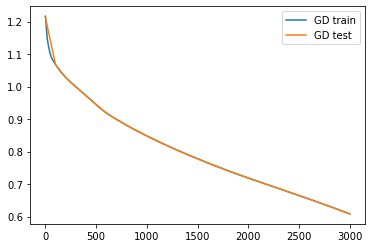

In [226]:
fig, ax = plt.subplots()

def train_test_plot(label,x_train,y_train,x_test,y_test,w_train=1000,w_test=10):
    ax.plot(x_train, pd.Series(np.array(y_train)).rolling(window=w_train).mean(), label=label+' train')
    ax.plot(x_test, pd.Series(np.array(y_test)).rolling(window=w_test).mean(), label=label+' test')
    ax.legend()
    return ax

result = 'GD'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=1,w_test=1)

#plt.xlim([500,2500])
#plt.ylim([0,0.2])

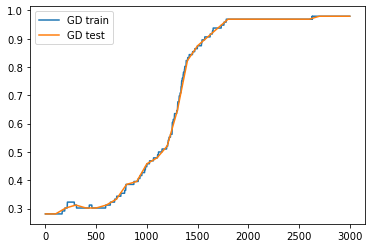

In [228]:
fig, ax = plt.subplots()

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=1,w_test=1)


# Optimization 2: SGD (minibatch 16)

In [232]:
batch_size = 16
test_dataset = tf.data.experimental.make_csv_dataset(
    test_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)
test_dataset_packed = test_dataset.map(pack_features_vector)

model = tf.keras.Sequential([
  tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(32, activation=tf.nn.relu),
  tf.keras.layers.Dense(16, activation=tf.nn.relu),
  tf.keras.layers.Dense(8, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

# https://keras.io/api/optimizers
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

results['SGD_16'] = fit(model, train=train_dataset_packed, test=test_dataset_packed, num_epochs=1001)

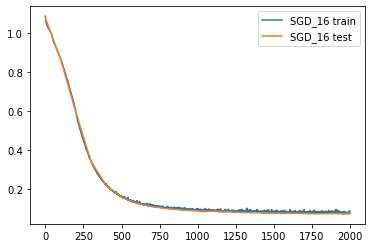

In [233]:
fig, ax = plt.subplots()

result = 'SGD_16'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=1,w_test=1)



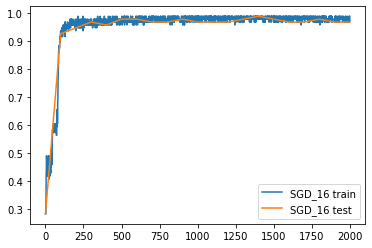

In [234]:
fig, ax = plt.subplots()

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=1,w_test=1)




# Optimization 3: SGD (minibatch 32) 

In [219]:
batch_size = 32
test_dataset = tf.data.experimental.make_csv_dataset(
    test_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)
test_dataset_packed = test_dataset.map(pack_features_vector)


model = tf.keras.Sequential([
  tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(32, activation=tf.nn.relu),
  tf.keras.layers.Dense(16, activation=tf.nn.relu),
  tf.keras.layers.Dense(8, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

# https://keras.io/api/optimizers
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

results['SGD_32'] = fit(model, train=train_dataset_packed, test=test_dataset_packed, num_epochs=2001)

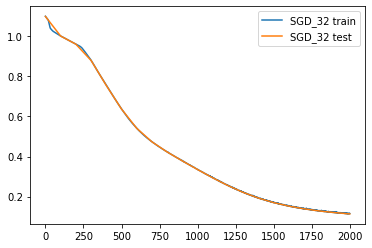

In [237]:
fig, ax = plt.subplots()

result='SGD_32'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=1,w_test=1)



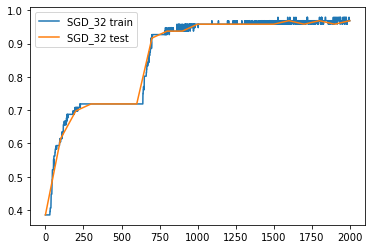

In [238]:
fig, ax = plt.subplots()

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=1,w_test=1)

# ax.set_ylim([0,0.2])

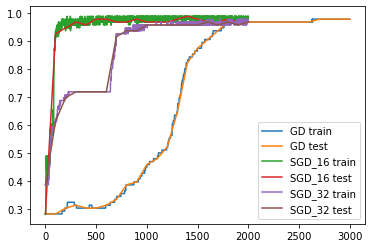

In [239]:
fig, ax = plt.subplots()

result='GD'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=1,w_test=1)

result='SGD_16'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=1,w_test=1)

result='SGD_32'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=1,w_test=1)




- **Why (in the world) is this happening?**
    - **I.e., why are smaller batch sizes converging faster??**
   
<br>  
   
*Didn't mention this last time; but, actually, minibatch also provides some regularization support!*
- Different subsets of data produce variable takes on gradients, so the gradients jump around a lot, which helps keep us from getting stuck in a rut. 

# Optimization 4: SGD (minibatch 32) with Batch Normalization

In [251]:

model = tf.keras.Sequential([
  tf.keras.Input(shape=(4,)),
  tf.keras.layers.Dense(64),
  tf.keras.layers.BatchNormalization(), # order of this line and the next is hotly debated
  tf.keras.layers.ReLU(),               # the "best" choice seems to vary empirically...
  tf.keras.layers.Dense(32),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(16),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(8),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(3)
])

# https://keras.io/api/optimizers
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

results['SGD_32_Batch_Normalization'] = fit(model, train=train_dataset_packed, test=test_dataset_packed, num_epochs=1501)

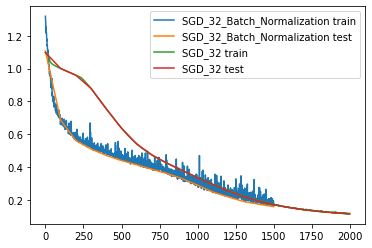

In [252]:
fig, ax = plt.subplots()

result='SGD_32_Batch_Normalization'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=1,w_test=1)

result='SGD_32'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=1,w_test=1)


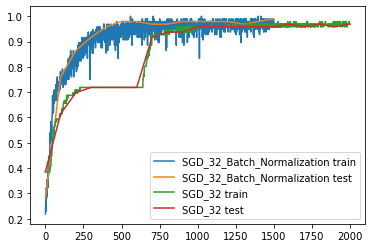

In [253]:
fig, ax = plt.subplots()

result='SGD_32_Batch_Normalization'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=1,w_test=1)

result='SGD_32'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=1,w_test=1)



- `BatchNorm` is helping speed up convergence... 
    - **What? Why??** *[Answer: because activations from one level to the next no longer...]*
    
    
- So last time we learned `BatchNorm` provides regularization...
    - **Oh, yeah... why?** *[Answer: it's harder to overfit a single data point because batches...]*

So we're seeing that `BatchNorm` BOTH provides regularization AND ALSO speeds up model fitting convergence: wow

# Optimization 5: SGD (minibatch 32) with Batch Normalization and Momentum

In [354]:

model = tf.keras.Sequential([
  tf.keras.Input(shape=(4,)),
  tf.keras.layers.Dense(64),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(32),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(16),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(8),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(3)
])

# https://keras.io/api/optimizers
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.2)

results['SGD_32_Batch_Normalization_Momentum'] = fit(model, train=train_dataset_packed, test=test_dataset_packed, num_epochs=1001, test_epoch_modulus=25)

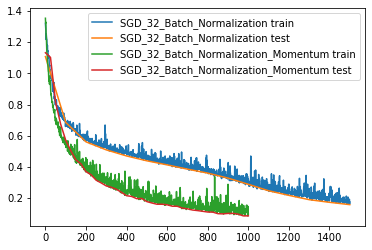

In [355]:
fig, ax = plt.subplots()


result='SGD_32_Batch_Normalization'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=1,w_test=1)

result='SGD_32_Batch_Normalization_Momentum'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=1,w_test=1)



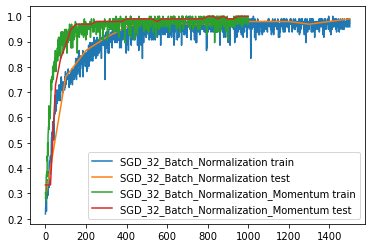

In [356]:
fig, ax = plt.subplots()

result='SGD_32_Batch_Normalization'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=1,w_test=1)


result='SGD_32_Batch_Normalization_Momentum'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=1,w_test=1)

# ax.set_ylim([0,0.2])

- **Why is this happening?**  I.e., why is momentum helping us converge faster?
- **When, then, would this not work?**

In [14]:
tf.keras.optimizers.SGD?

# Optimization 6: SGD (minibatch 32) with Batch Normalization and Nesterov Momentum

In [385]:

model = tf.keras.Sequential([
  tf.keras.Input(shape=(4,)),
  tf.keras.layers.Dense(64),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(32),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(16),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(8),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(3)
])

# https://keras.io/api/optimizers
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0025, momentum=0.25, nesterov=True)

results['SGD_32_Batch_Normalization_Nesterov_Momentum'] = fit(model, train=train_dataset_packed, test=test_dataset_packed, num_epochs=751, test_epoch_modulus=25)

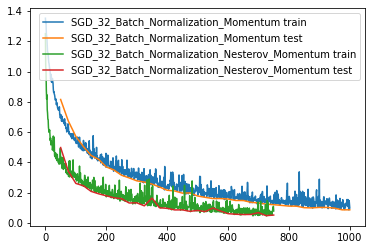

In [386]:
fig, ax = plt.subplots()

result='SGD_32_Batch_Normalization_Momentum'
results[result]['test_epoch'][0] = np.NaN
results[result]['test_epoch'][1] = np.NaN
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=1,w_test=1)


result='SGD_32_Batch_Normalization_Nesterov_Momentum'
results[result]['test_epoch'][0] = np.NaN
results[result]['test_epoch'][1] = np.NaN
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=1,w_test=1)




- **Why has the Nesterove version done better?**

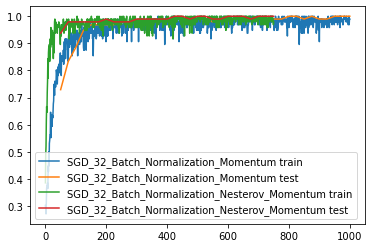

In [387]:
fig, ax = plt.subplots()


result='SGD_32_Batch_Normalization_Momentum'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=1,w_test=1)


result='SGD_32_Batch_Normalization_Nesterov_Momentum'
results[result]['test_epoch'][0] = np.NaN
results[result]['test_epoch'][1] = np.NaN
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=1,w_test=1)

# ax.set_ylim([0,0.2])

# Optimization 7: AdaDelta (minibatch 32) Batch Normalization

In [363]:

model = tf.keras.Sequential([
  tf.keras.Input(shape=(4,)),
  tf.keras.layers.Dense(64),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(32),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(16),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(8),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(3)
])

# https://keras.io/api/optimizers
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.3, rho=0.95, epsilon=1e-07)

results['SGD_32_Batch_Normalization_AdaDelta'] = fit(model, train=train_dataset_packed, test=test_dataset_packed, num_epochs=501, test_epoch_modulus=25)



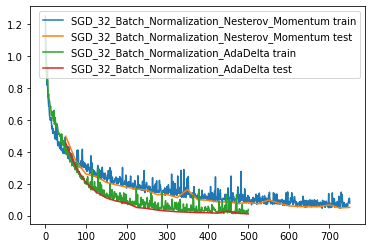

In [388]:
fig, ax = plt.subplots()

result='SGD_32_Batch_Normalization_Nesterov_Momentum'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=1,w_test=1)

result='SGD_32_Batch_Normalization_AdaDelta'
results[result]['test_epoch'][0] = np.NaN
results[result]['test_epoch'][1] = np.NaN
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=1,w_test=1)



1. Would the "learning rate" change if we re-initialized `tf.keras.optimizers.SGD` in the middle of model fitting
    - i.e, `tf.keras.optimizers.SGD(learning_rate=0.0025, momentum=0.25, nesterov=True)`
    - Would any convergence rate characterisitics change?

*Note that we can provide a "learning rate schedule"!*


2. Adadelta is a version of Adagrad that decays rather than accumulates gradient history: what is rho?
    - Is there a "momentum" tuning parameter for Adadelta/Adagrad?
    
3. Would the "learning rate" change if we re-initialized `tf.keras.optimizers.Adadelta` in the middle of model fitting
    - i.e, `tf.keras.optimizers.Adadelta(learning_rate=0.3, rho=0.95, epsilon=1e-07)`
    - Would any convergence rate characterisitics change?
    
*So these are two very different strategies!* 

In [21]:

#tf.keras.optimizers.SGD?
tf.keras.optimizers.Adadelta?

# A couple good places to start differentiating between all these optimizer choices!
# https://www.quora.com/What-are-differences-between-update-rules-like-AdaDelta-RMSProp-AdaGrad-and-AdaM
# https://stackoverflow.com/questions/36162180/gradient-descent-vs-adagrad-vs-momentum-in-tensorflow


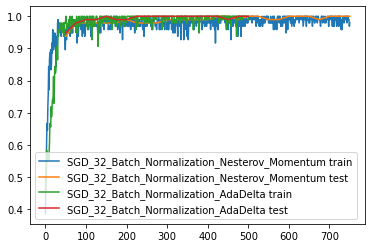

In [389]:
fig, ax = plt.subplots()

result='SGD_32_Batch_Normalization_Nesterov_Momentum'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=1,w_test=1)

result='SGD_32_Batch_Normalization_AdaDelta'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=1,w_test=1)


# Optimization 8: RMSProp (minibatch 32) Batch Normalization and Momentum

In [405]:

model = tf.keras.Sequential([
  tf.keras.Input(shape=(4,)),
  tf.keras.layers.Dense(64),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(32),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(16),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(8),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(3)
])

# https://keras.io/api/optimizers
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00075, rho=0.8, momentum=0.35, epsilon=1e-07)

results['SGD_32_Batch_Normalization_RMSProp'] = fit(model, train=train_dataset_packed, test=test_dataset_packed, num_epochs=351, test_epoch_modulus=25)



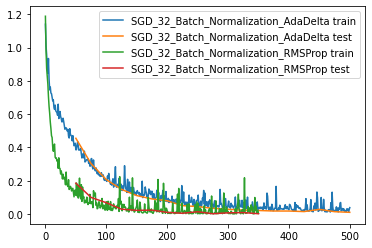

In [406]:
fig, ax = plt.subplots()

result='SGD_32_Batch_Normalization_AdaDelta'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=1,w_test=1)


result='SGD_32_Batch_Normalization_RMSProp'
results[result]['test_epoch'][0] = np.NaN
results[result]['test_epoch'][1] = np.NaN

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=1,w_test=1)


- **Are you surprised we've been able to surpass `AdaDelta` with `RMSProp`?**

*Hint:*
- `tf.keras.optimizers.Adadelta(learning_rate=0.3, rho=0.95, epsilon=1e-07)`
- `tf.keras.optimizers.RMSprop(learning_rate=0.00075, rho=0.8, momentum=0.35, epsilon=1e-07)`


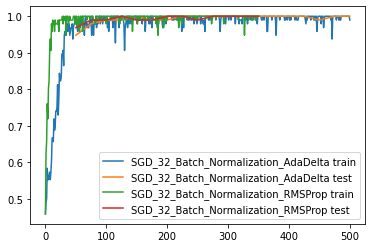

In [408]:
fig, ax = plt.subplots()

result='SGD_32_Batch_Normalization_AdaDelta'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=1,w_test=1)


result='SGD_32_Batch_Normalization_RMSProp'
results[result]['test_epoch'][0] = np.NaN
results[result]['test_epoch'][1] = np.NaN

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=1,w_test=1)



# Optimization 9: Adam (minibatch 32) Batch Normalization

In [426]:
model = tf.keras.Sequential([
  tf.keras.Input(shape=(4,)),
  tf.keras.layers.Dense(64),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(32),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(16),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(8),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(3)
])

# https://keras.io/api/optimizers
#RMSProp settings: learning_rate=0.00075, rho=0.8, momentum=0.35
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.35, beta_2=0.8, epsilon=1e-07)


results['SGD_32_Batch_Normalization_Adam'] = fit(model, train=test_dataset_packed, test=train_dataset_packed, num_epochs=351, test_epoch_modulus=25)



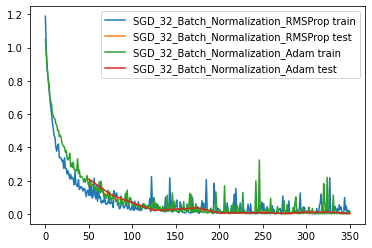

In [427]:
fig, ax = plt.subplots()

result='SGD_32_Batch_Normalization_RMSProp'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=1,w_test=1)


result='SGD_32_Batch_Normalization_Adam'
results[result]['test_epoch'][0] = np.NaN
results[result]['test_epoch'][1] = np.NaN

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=1,w_test=1)


In [ ]:
# what are the differences betweeen these two?

# tf.keras.optimizers.RMSprop(learning_rate=0.00075, rho=0.8, momentum=0.35, epsilon=1e-07)
# tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.35, beta_2=0.8, epsilon=1e-07)

#tf.keras.optimizers.Adam?
#tf.keras.optimizers.RMSprop?

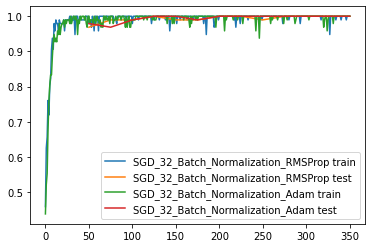

In [428]:
fig, ax = plt.subplots()

result='SGD_32_Batch_Normalization_RMSProp'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=1,w_test=1)


result='SGD_32_Batch_Normalization_Adam'
ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=1,w_test=1)


## Optimization for NN

minimizes "empirical risk minimization" as opposed to actual "risk minimization"

- i.e., minimizing $J(\theta; X, Y)$ in the hopes of minimizing $P$ (something else) is an interesting sort of optimization game...
- That's why we use our regularization techniques: 

$$E_{(x,y)\sim \hat p_{data}} L(f(\theta; X), Y) + \alpha\Omega(\theta) \text{ versus } E_{(x,y)\sim p_{data}} L(f(\theta; X), Y)$$

- where the latter is known as the *risk* and the former $E_{(x,y)\sim \hat p_{data}} L(f(\theta; X), Y)$ is known as *empirical risk*
- *This is what makes a machine learning problem versus an optimization problem*
    - and of course this *empirical risk* is prone to overfitting, hence $+ \alpha\Omega(\theta)$
    - Thus, our halting rule is no longer that "gradient is approximately 0"
        - Actually, the gradient of the objective function often still has a large magnitude
        
        
Another issue is that we often rely on surrogate loss functions as proxies for actual risk of interest:
- 0-1 loss is the cononical example of this...
- we instead use log-likelihood as a surrogate; however, it works very well as it contains "more information" than just 0-1 loss...
    
    
SGD relies upon estimates of expected gradient (using a subset of the data)
- Since uncertainty reduces by a factor of $\frac{1}{\sqrt{n}}$, it can be computationally more efficient to follow "pretty good" gradient directions using a subset of the data set rather than "perfect" gradient directions using the whole data, which can be much, much more computationally expensive (returns are not "linear" in computation)
 - naturally, the data must be randomized (via shuffling) to maintain correct expectations in each batch
 - On the other hand, while super small batches (e.g., n=1) have been seen to produce often the best generalization error, they require super small $\alpha$, and often under utilize computational resources (time to process 1 is the same as to process 32).
    - Batch size is often a computational bottleneck, and e.g., many GPU architectures, operate most effectively in sizes of powers of 2, e.g., 32 up to 256, sometimese 16
    - **Small batches seem to provide some regularization... it seems the noise added to the learning process projects against overfitting**
- Gradients are usually fairly robust at sample sizes of $\sim 100$; however, second order (Hessian) based methods can be very unstable numerically... requiring batch sizes of $\sim 10,000$
        
        
         


## Adaptive Learning Rates
- delta-bar-delta algorithm: if derivative in a particular direction stays the same sign, increase it's magnitude, otherwise, decrease it

- all/most of the various optimizers from the text make up the primary content of the in-class quiz
    - i.e., what are they, what differtiates them, etc.

## Batch Normalization
- backpropegation updates change the mean and standard deviation parameters as well, so the activations come out standardized, always
- $\phi(WX+b)$ is replaced with $\phi\left(\frac{WX-\mu(WX)}{\sigma(WX)}\gamma+\beta\right)$
- This means weight updates at one layer have less influence on updates at another layer


## SGD
- learning rate probably actually needs to decreasing with time $\epsilon_k$
- momentum introduces *velocity* and decay parameter $\alpha$: $v \leftarrow \alpha v + \epsilon \hat \nabla_L$

- Initialization

    - weights need to be chosen so forward and backward propegation don't explode or vanish.
        - if activations are too small going forward, or gradient variance is too wild going backward, then there's problems...
    - biases and other "known functionality" parameters are placed on reasonable, heuristically values.
        - biases can match known empirical marginals
        - or for ReLU it's sometimes useful to set bias to 0.1 to avoid immediate saturation of the activation function at 0 (or 1.0 for forget gates of LSTMs so parameters can have learning)

    - "breaking symmetry" can be done fairly well with random weights
        - Gaussian/Uniform both appear to work fine
        - larger scales breaks more symmetry; but, can explode activations and gradients in forward and backward propegation, respectively
        - According to weight decay regularization it might be better to pull weights towards zero... so perhaps smaller scale (closer to zero) is better?
            - Both Early stopping and areas of flatter gradient cause weight values to "stop" and thus be more similar to their initial values... 

    - Normalized initialization (of the "Glorot and Bengio") variety have been proposed
        - $W_{ij} \sim U\left(-\frac{1}{\sqrt{m_{inputs}}},\frac{1}{\sqrt{m_{inputs}}}\right)$ or
        - $W_{ij} \sim U\left(-\sqrt{\frac{6}{m_{inputs}+n_{inputs}}},\sqrt{\frac{6}{m_{inputs}+n_{inputs}}}\right)$ 
        - this latter option is based on chained matrix multiplications with no non-linearities and attemps to encourage all layers to have (a) equal activation variances, and (b) equal gradient variances; but, it does appear to work well on non-linear counterparts as well 
        
    - Another idea proposes "initializing to random orthogonal matrices, with a carefully chosen scaling or gain factors that accounts for the nonlinearity applied at each layer" in order to ensure "that the total number of training iterations required to reach convergence is independent of depth."
        - generally, regardless of "matrix orthogonality" or not, the concept here to ensure gradient norms are constant across layers can address exploding/vanishing gradients
        - however, these ideas for "optimal" weights have not proven to generally produce the best generalization...
        - either (a) preserving similar norms is not so important, (b) learning may destroy these intial "good properties", or (c) these may inadvertantly increase generalization error while increasing optimization speed
        
    - "sparse initiallization" seeks to initialize each unit "to have exactly $k$ nonzero weights... to keep the total amount of input to the unit independent from the number of inputs $m$ without making the magnitude of individual weight elements shrink with $m$."
        - this "helps to achieve more diversity among the units at initialization time"
        - but uses a "strong prior on the weights that are chosen to have large Gaussian values... it takes a long time for gradient descent to shrink “incorrect” large values"
            - this works particularly poorly for maxout units which have multiple carefully coordinate filters
            
    - Unsupervised weights can be used to initialize supervised learning weights
        - This "may yield faster convergence and better generalization because they encode information about the distribution in the initial parameters of the model" and/or "set the parameters to have the right scale or set different units to compute different functions from each other. 

            
   

# Things you should be aware of after reading Ch 8.

## pretraining/transfer learning/Fitnets/Auxilliary heads
- there are quite a few ideas in the above topics proposing how to help initialize complex network architectures
- additionally, network/activation designs meant to better propegate gradient flow seem potentially very promising, and have often proven very useful...
- *continuation methods* and *sequential optimization specifications* that should chain towards a good overall solution is another interesting idea...
    - simulated annealing is a related technique
    - curriculum learning -- how data is fed to the algorithm -- also seems to show a lot of progress
    
### Some very key clarifying mathy ideas

    
- *Ill-conditioning* of the Hessian
    - Taylor series expansion approximates the change in the cost for an $\epsilon$-step in the direction of the gradient $g$ as $\frac{1}{2} \epsilon^2 g^T H g - \epsilon g^Tg$
        - if the former term exceeds the later term then the algorithm is "stuck" since the cost increases rather than decreases
        - if $g^Tg$ does not decrease over the course of training (which often happens even in "successful" training runs), but $g^T H g$ gets larger, then "learning becomes very slow despite the presence of a strong gradient because the learning rate must be shrunk to compensate for even stronger curvature"
    
- page 278 (and thereabouts) discusses how (*for a representative random sample*), the first pass through the data with SGD follows the gradient of true generalization error.
    - additional ephocs now mean the sample is counted multiple times, so it's no longer following an unbiased gradient path of true generalization error.

    
    
### Some conversation about cost function surfaces:
- local minima that pose no problelm for the loss function are
    - "weight space symmetry" is a kind of "non-convexity"
    - "scaling and inverse scaling in and out of a ReLU"
- local minima are actually thought not to be very prevalent compared to saddle points
- saddle points would seem to be problematic, but SGD appears to be able to escape them pretty easily 
- second order methods (such as Newton's) would suffer from saddle points, and it's thought this is why they seem to not perform so well for neural networks
- flat regions corresponding to high costs would be problematic for all gradient-based methods...
- cliff structures, which appear in RNNs as a result of repeated multiplications of $W$, are very problematic... "gradient clipping" (limiting of big jumps) is often used to attempt to help this issue
    - If repeated applications of $W$ are used the gradient explodes or vanishes... either way it becomes very hard to know which direction to move in for improvement
    
- gradient estimation can be bad...
- local gradient can be different than global structure

# Second order optimization methods exist
1. Newton's method... very computationally expensive...
2. (nonlinear) conjugate gradients
3. BFGS: an updating approximation to the inverse Hessian is stored
    - L-BFGS: retains less of the past inverse Hessian information

## Other optimization methods exist
- Coordinate descent is a cycle through optimizing one block of parameters with the others held fixed.
    - that's a bit like Gibbs sampling, eh?
- Polyak Averaging, often using an exponential decay running average $\theta^{(t)} = \alpha \hat \theta^{(t-1)} + (1-\alpha) \theta^{(t)}$
    - comes with strong convergence guarantees for convex problems, and seems fairly nice for non-convex NN problems as well. 
    
